In [ ]:
import findspark
findspark.init()

import pyspark

from pyspark.sql import functions as f
from pyspark.sql import SparkSession
from pyspark.sql.types import (StringType, IntegerType, FloatType,
                               DecimalType, StructField, StructType)


# Crear una sesión de Spark
spark = SparkSession.builder.appName("tarea3")\
                            .config("spark.driver.extraClassPath", "postgresql-42.2.14.jar") \
                            .config("spark.executor.extraClassPath", "postgresql-42.2.14.jar") \
                            .getOrCreate()


data = spark.read.format("csv") \
               .option("path", "Diabetes Binary Classification.csv") \
               .option("header", True) \
               .option("inferSchema", True) \
               .load()





In [ ]:
# Mostrar el esquema de los datos
data.printSchema()

# Visualizar las primeras filas de los datos
data.show()


root
 |-- Number of times pregnant: integer (nullable = true)
 |-- Plasma glucose concentration a 2 hours in an oral glucose tolerance test: integer (nullable = true)
 |-- Diastolic blood pressure (mm Hg): integer (nullable = true)
 |-- Triceps skin fold thickness (mm): integer (nullable = true)
 |-- 2-Hour serum insulin (mu U/ml): integer (nullable = true)
 |-- Body mass index (weight in kg/(height in m)^2): double (nullable = true)
 |-- Diabetes pedigree function: double (nullable = true)
 |-- Age (years): integer (nullable = true)
 |-- Class variable (0 or 1): integer (nullable = true)

+------------------------+------------------------------------------------------------------------+--------------------------------+--------------------------------+------------------------------+----------------------------------------------+--------------------------+-----------+-----------------------+
|Number of times pregnant|Plasma glucose concentration a 2 hours in an oral glucose tolerance te

In [ ]:
#cambio el nombre de los atributos
df = data \
    .withColumnRenamed("Number of times pregnant", "X1") \
    .withColumnRenamed("Plasma glucose concentration a 2 hours in an oral glucose tolerance test", "X2") \
    .withColumnRenamed("Diastolic blood pressure (mm Hg)", "X3") \
    .withColumnRenamed("Triceps skin fold thickness (mm)", "X4") \
    .withColumnRenamed("2-Hour serum insulin (mu U/ml)", "X5") \
    .withColumnRenamed("Body mass index (weight in kg/(height in m)^2)", "X6") \
    .withColumnRenamed("Diabetes pedigree function", "X7") \
    .withColumnRenamed("Age (years)", "X8") \
    .withColumnRenamed("Class variable (0 or 1)", "Y")

#nuevo esquema
df.printSchema()

#primeras filas del dataframe
df.show()


root
 |-- X1: integer (nullable = true)
 |-- X2: integer (nullable = true)
 |-- X3: integer (nullable = true)
 |-- X4: integer (nullable = true)
 |-- X5: integer (nullable = true)
 |-- X6: double (nullable = true)
 |-- X7: double (nullable = true)
 |-- X8: integer (nullable = true)
 |-- Y: integer (nullable = true)

+---+---+---+---+---+----+-----+---+---+
| X1| X2| X3| X4| X5|  X6|   X7| X8|  Y|
+---+---+---+---+---+----+-----+---+---+
|  6|148| 72| 35|  0|33.6|0.627| 50|  1|
|  1| 85| 66| 29|  0|26.6|0.351| 31|  0|
|  8|183| 64|  0|  0|23.3|0.672| 32|  1|
|  1| 89| 66| 23| 94|28.1|0.167| 21|  0|
|  0|137| 40| 35|168|43.1|2.288| 33|  1|
|  5|116| 74|  0|  0|25.6|0.201| 30|  0|
|  3| 78| 50| 32| 88|31.0|0.248| 26|  1|
| 10|115|  0|  0|  0|35.3|0.134| 29|  0|
|  2|197| 70| 45|543|30.5|0.158| 53|  1|
|  8|125| 96|  0|  0| 0.0|0.232| 54|  1|
|  4|110| 92|  0|  0|37.6|0.191| 30|  0|
| 10|168| 74|  0|  0|38.0|0.537| 34|  1|
| 10|139| 80|  0|  0|27.1|1.441| 57|  0|
|  1|189| 60| 23|846|30.1|

In [ ]:
from pyspark.ml.feature import VectorAssembler

#crear un solo vector de features
assembler = VectorAssembler(inputCols=df.columns[:-1], outputCol="features")
assembled_df = assembler.transform(df)

vector_df = assembled_df.select(['features','Y'])

vector_df.show()



+--------------------+---+
|            features|  Y|
+--------------------+---+
|[6.0,148.0,72.0,3...|  1|
|[1.0,85.0,66.0,29...|  0|
|[8.0,183.0,64.0,0...|  1|
|[1.0,89.0,66.0,23...|  0|
|[0.0,137.0,40.0,3...|  1|
|[5.0,116.0,74.0,0...|  0|
|[3.0,78.0,50.0,32...|  1|
|[10.0,115.0,0.0,0...|  0|
|[2.0,197.0,70.0,4...|  1|
|[8.0,125.0,96.0,0...|  1|
|[4.0,110.0,92.0,0...|  0|
|[10.0,168.0,74.0,...|  1|
|[10.0,139.0,80.0,...|  0|
|[1.0,189.0,60.0,2...|  1|
|[5.0,166.0,72.0,1...|  1|
|[7.0,100.0,0.0,0....|  1|
|[0.0,118.0,84.0,4...|  1|
|[7.0,107.0,74.0,0...|  1|
|[1.0,103.0,30.0,3...|  0|
|[1.0,115.0,70.0,3...|  1|
+--------------------+---+
only showing top 20 rows



<Axes: >

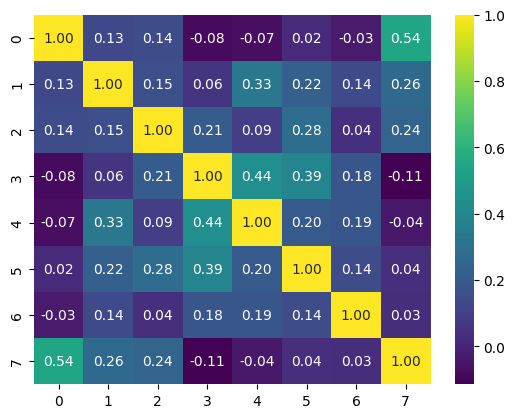

In [ ]:
# Con la representación de vectores podemos calcular correlaciones
from pyspark.ml.stat import Correlation
import seaborn as sns
import matplotlib.pyplot as plt

pearson_matrix = Correlation.corr(vector_df, 'features').collect()[0][0]

sns.heatmap(pearson_matrix.toArray(), annot=True, fmt=".2f", cmap='viridis')

In [ ]:
from pyspark.ml.feature import StandardScaler

standard_scaler = StandardScaler(inputCol='features', outputCol='scaled_features')
scale_model = standard_scaler.fit(vector_df)

scaled_df = scale_model.transform(vector_df)
scaled_df.show()

+--------------------+---+--------------------+
|            features|  Y|     scaled_features|
+--------------------+---+--------------------+
|[6.0,148.0,72.0,3...|  1|[1.78063837321943...|
|[1.0,85.0,66.0,29...|  0|[0.29677306220323...|
|[8.0,183.0,64.0,0...|  1|[2.37418449762590...|
|[1.0,89.0,66.0,23...|  0|[0.29677306220323...|
|[0.0,137.0,40.0,3...|  1|[0.0,4.2849165233...|
|[5.0,116.0,74.0,0...|  0|[1.48386531101619...|
|[3.0,78.0,50.0,32...|  1|[0.89031918660971...|
|[10.0,115.0,0.0,0...|  0|[2.96773062203238...|
|[2.0,197.0,70.0,4...|  1|[0.59354612440647...|
|[8.0,125.0,96.0,0...|  1|[2.37418449762590...|
|[4.0,110.0,92.0,0...|  0|[1.18709224881295...|
|[10.0,168.0,74.0,...|  1|[2.96773062203238...|
|[10.0,139.0,80.0,...|  0|[2.96773062203238...|
|[1.0,189.0,60.0,2...|  1|[0.29677306220323...|
|[5.0,166.0,72.0,1...|  1|[1.48386531101619...|
|[7.0,100.0,0.0,0....|  1|[2.07741143542266...|
|[0.0,118.0,84.0,4...|  1|[0.0,3.6906580274...|
|[7.0,107.0,74.0,0...|  1|[2.07741143542

Guardar y leer desde postgres

In [ ]:
# Almacenar el conjunto de datos limpio en la base de datos

df \
    .write \
    .format("jdbc") \
    .mode('overwrite') \
    .option("url", "jdbc:postgresql://host.docker.internal:5433/postgres") \
    .option("user", "postgres") \
    .option("password", "testPassword") \
    .option("dbtable", "tarea3") \
    .save()

In [ ]:
# Cargar el conjunto de datos. Esta vez desde la base de datos

# Reading single DataFrame in Spark by retrieving all rows from a DB table.
scaled_df = spark \
    .read \
    .format("jdbc") \
    .option("url", "jdbc:postgresql://host.docker.internal:5433/postgres") \
    .option("user", "postgres") \
    .option("password", "testPassword") \
    .option("dbtable", "tarea3") \
    .load()
df.show()

Clasificacion binaria

Modelo 1. Logistic regression

In [ ]:
from pyspark.ml.classification import LogisticRegression
from pyspark.ml.evaluation import BinaryClassificationEvaluator
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator


# entrenamiento y validación final (80% para entrenamiento, 20% para validación final)
(train_df, validation_final_df) = scaled_df.randomSplit([0.8, 0.2], seed=42)

#modelo
model_lr = LogisticRegression(featuresCol="scaled_features", labelCol="Y")

#cuadrícula de parámetros para el grid search en k-fold cross-validation
param_grid = ParamGridBuilder().build()

# evaluador para la métrica
evaluator = BinaryClassificationEvaluator(labelCol="Y", metricName="areaUnderROC")

# k-fold cross-validation
crossval = CrossValidator(estimator=model_lr,
                          estimatorParamMaps=param_grid,
                          evaluator=evaluator,
                          numFolds=5)  # Puedes ajustar el número de folds según tus preferencias

#entrenamiento
model_lr_cv = crossval.fit(train_df)

#predicciones
predictions = model_lr_cv.transform(validation_final_df)

# Calcular el AUC para el primer modelo
auc_model1 = evaluator.evaluate(predictions)

# Imprimir los resultados
print(f"AUC para Modelo 1: {auc_model1}")



#resultados en la base de datos
predictions.select("features", "scaled_features", "Y", "prediction").write.jdbc(url="jdbc:postgresql://localhost:5432/postgres", table="modelo1", mode="overwrite", properties={"user": "postgres", "password": "testPassword"})

AUC para Modelo 1: 0.8840048840048842


Modelo 2. RandomForestClassifier

In [ ]:
from pyspark.ml.classification import RandomForestClassifier

# modelo
model_rf = RandomForestClassifier(featuresCol="scaled_features", labelCol="Y", numTrees=100)

evaluator_rf = BinaryClassificationEvaluator(labelCol="Y", metricName="areaUnderROC")

#k-fold cross-validation
crossval_rf = CrossValidator(estimator=model_rf,
                              estimatorParamMaps=param_grid,
                              evaluator=evaluator_rf,
                              numFolds=5)

#entrenamiento
model_rf_cv = crossval_rf.fit(train_df)

#predicciones en el conjunto de validación final
predictions_rf = model_rf_cv.transform(validation_final_df)

# Calcular el AUC para el segundo modelo
auc_model2 = evaluator_rf.evaluate(predictions_rf)

print(f"AUC para Modelo 2: {auc_model2}")

#resultados en la base de datos
predictions_rf.select("features", "scaled_features", "Y", "prediction").write.jdbc(url="jdbc:postgresql://localhost:5432/postgres", table="modelo2", mode="overwrite", properties={"user": "postgres", "password": "testPassword"})


AUC para Modelo 2: 0.8565323565323567


Basado en los resultados de ambos modelos, podemos observar que, utilizando el metodo de AUC, el modelo 1 correspondiente a Logisitic Regression es mas preciso que el modelo 2 RandomForestClassifier. Obteniendo el primero un 88.4 % de preciosion sobre un 85.6% para el segundo.